# CYCLING DATA QUALITY

## (03b) Feature Matching

### Why?

The feature matching takes it starting point in the reference data and attempts to identify corresponding features in the OSM data set. Feature matching is a necessary precondition to compare single features rather than feature characteristics on study area a grid cell level, as well as for merging two data sets.

### How?

Matching features in two road datasets with each their way of digitizing features and a potential one-to-many relationship between edges (for example in the case where one data set only maps road center lines, while the other map the geometries of each bike lane) is not a trivial task.

The method used here converts all network edges to smaller segments of a uniform length before looking for a potential match between the reference and the OSM data. The matching is done on the basis of the buffered distance between objects, the angle, and the undirected Hausdorff distance, and is based on the work of [Koukoletsos et al. (2012)](http://www.geog.leeds.ac.uk/groups/geocomp/2011/papers/koukoletsos.pdf) and [Will (2014)](https://www.semanticscholar.org/paper/Development-of-an-automated-matching-algorithm-to-%3A-Will/b3b77d579077b967820630db56522bef31654f21).

Based on the matching results, the following is computed:
- The number and length of matched and unmatched edges, in total and per grid cell
- A comparison of the attributes of the matched edges (is their classification of cycling infrastructure as protected or unprotected the same?)

### What could it mean?

One the feature matching is complete, it is important to visually explore the results, since the success rate of the matching influences how the analysis of number of matches should be interpreted.

If the features in the two data sets have been digitized in very different ways - e.g. if one data set has digitized bike tracks as mostly straight lines, while the other includes more winding tracks, the matching will fail. This is also the case if they are placed too far from each other. If it visually can be confirmed that the same features do exist in both data sets, a lack of matches indicates that the geometries in the two data sets are too different. If it on the other hand can be confirmed that most real corresponding features have been identified, a lack of matches in an area indicates errors of commission or omission.

*The feature matching is fairly computationally expensive and will take a while to compute. For the testing data provided in this repository (with around 8000 meters of OSM network) the cell takes around 20 minutes to run.*

***

**Sections:**

1. Feature matching
    - Plot results: matched vs. unmatched features
2. Analyze results
    - Matched features by infrastructure type
    - Matched features per grid cell
3. Summary
4. Save results

_______________



In [80]:
import json
import numbers
import os.path
import pickle

import contextily as cx
import folium
import geopandas as gpd
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import osmnx as ox
import pandas as pd
import yaml

from src import evaluation_functions as eval_func
from src import matching_functions as match_func
from src import plotting_functions as plot_func

# Read in dictionaries with settings
%run ../settings/yaml_variables.py
%run ../settings/plotting.py
%run ../settings/tiledict.py
%run ../settings/paths.py

# # Load data
%run ../settings/load_osmdata.py
%run ../settings/load_refdata.py
%run ../settings/df_styler.py

# Combine grid geodataframes
grid = osm_grid.merge(ref_grid)
assert len(grid) == len(osm_grid) == len(ref_grid)

OSM graphs loaded successfully!
OSM data loaded successfully!
Reference graphs loaded successfully!
Reference data loaded successfully!


__________________

## 1. Feature Matching

<div class="alert alert-block alert-info">
<b>User configurations</b>
<br>
<br>
In the feature matching, the user must indicate:
<ul>
    <li>the segment length (length of the segments in meters that all features are split into before the matching) (<span style="font-family: monospace">segment_length</span>).</li>
    <li>the buffer distance used to find potential matches (i.e. the max distance between two segments that could represent the same object) (<span style="font-family: monospace">buffer_dist</span>).</li>
    <li>the maximum Hausdorff distance between features that can be considered matches (in this context it refers to the maximum distance between two geometries. For example, a segment A with a length of 25 meters might be within a 10 meter buffer distance of segment B, but if they are perpendicular to each other, the Hausdorff distance will be greater than 10 meters) (<span style="font-family: monospace">hausdorff_threshold</span>).</li>
    <li>the angular threshold between segments before they are no longer considered a potential match (<span style="font-family: monospace">angular_threshold</span>).</li>
</ul>
</div>

In [81]:
# DEFINE FEATURE MATCHING USER SETTINGS
segment_length = 10  # The shorter the segments, the longer the matching process will take. For cities with a gridded street network with streets as straight lines, longer segments will usually work fine
buffer_dist = 15
hausdorff_threshold = 17
angular_threshold = 30

for s in [segment_length, buffer_dist, hausdorff_threshold, angular_threshold]:
    assert isinstance(s, int) or isinstance(s, float), print(
        "Settings must be integer or float values!"
    )

In [82]:
osm_segments = match_func.create_segment_gdf(
    osm_edges_simplified, segment_length=segment_length
)
osm_segments.rename(columns={"osmid": "org_osmid"}, inplace=True)
osm_segments["osmid"] = osm_segments[
    "edge_id"
]  # Because matching function assumes an id column names osmid as unique id for edges

osm_segments.set_crs(study_crs, inplace=True)
osm_segments.dropna(subset=["geometry"], inplace=True)

ref_segments = match_func.create_segment_gdf(
    ref_edges_simplified, segment_length=segment_length
)
ref_segments.set_crs(study_crs, inplace=True)
ref_segments.rename(columns={"seg_id": "seg_id_ref"}, inplace=True)
ref_segments.dropna(subset=["geometry"], inplace=True)

print("Segments created successfully!")

matches_fp = f"../../results/compare/{study_area}/data/segment_matches_{buffer_dist}_{hausdorff_threshold}_{angular_threshold}.pickle"

if os.path.exists(matches_fp):
    with open(matches_fp, "rb") as fp:
        segment_matches = pickle.load(fp)
    print(
        f"Segment matching has already been performed. Loading existing segment matches, matched with a buffer distance of {buffer_dist} meters, a Hausdorff distance of {hausdorff_threshold} meters, and a max angle of {angular_threshold} degrees."
    )

else:
    print(
        f"Starting matching process using a buffer distance of {buffer_dist} meters, a Hausdorff distance of {hausdorff_threshold} meters, and a max angle of {angular_threshold} degrees."
    )

    buffer_matches = match_func.overlay_buffer(
        reference_data=ref_segments,
        osm_data=osm_segments,
        ref_id_col="seg_id_ref",
        osm_id_col="seg_id",
        dist=buffer_dist,
    )

    print("Buffer matches found! Continuing with final matching process...")

    segment_matches = match_func.find_matches_from_buffer(
        buffer_matches=buffer_matches,
        osm_edges=osm_segments,
        reference_data=ref_segments,
        angular_threshold=angular_threshold,
        hausdorff_threshold=hausdorff_threshold,
    )

    print("Feature matching completed!")

    with open(matches_fp, "wb") as f:
        pickle.dump(segment_matches, f)

Segments created successfully!
Segment matching has already been performed. Loading existing segment matches, matched with a buffer distance of 15 meters, a Hausdorff distance of 17 meters, and a max angle of 30 degrees.


In [83]:
# Summarize feature matching results

osm_matched_ids, osm_undec = match_func.summarize_feature_matches(
    osm_segments, segment_matches, "seg_id", "osmid", osm=True
)

ref_matched_ids, ref_undec = match_func.summarize_feature_matches(
    ref_segments, segment_matches, "seg_id_ref", "edge_id", osm=False
)

### Feature matching results

In [84]:
# Folium plot of segment matches

osm_edges_simplified_folium = plot_func.make_edgefeaturegroup(
    gdf=osm_edges_simplified,
    mycolor=pdict["osm_seg"],
    myweight=pdict["osm_weight"],
    nametag="OSM all edges",
    show_edges=True,
    myalpha=pdict["osm_alpha"],
)

ref_edges_simplified_folium = plot_func.make_edgefeaturegroup(
    gdf=ref_edges_simplified,
    mycolor=pdict["ref_seg"],
    myweight=pdict["ref_weight"],
    nametag="Reference all edges",
    show_edges=True,
    myalpha=pdict["ref_alpha"],
)

segment_matches_folium = plot_func.make_edgefeaturegroup(
    gdf=segment_matches,
    mycolor=pdict["mat_seg"],
    myweight=pdict["mat_weight"],
    nametag="Segment matches",
    show_edges=True,
    myalpha=pdict["mat_alpha"],
)

m = plot_func.make_foliumplot(
    feature_groups=[
        osm_edges_simplified_folium,
        ref_edges_simplified_folium,
        segment_matches_folium,
    ],
    layers_dict=folium_layers,
    center_gdf=osm_nodes_simplified,
    center_crs=osm_nodes_simplified.crs,
)

bounds = plot_func.compute_folium_bounds(osm_nodes_simplified)
m.fit_bounds(bounds)

m.save(
    compare_results_inter_maps_fp
    + f"segment_matches_{buffer_dist}_{hausdorff_threshold}_{angular_threshold}.html"
)

display(m)

AttributeError: module 'src.plotting_functions' has no attribute 'compute_folium_bounds'

### Matched and unmatched features in OSM and reference data sets

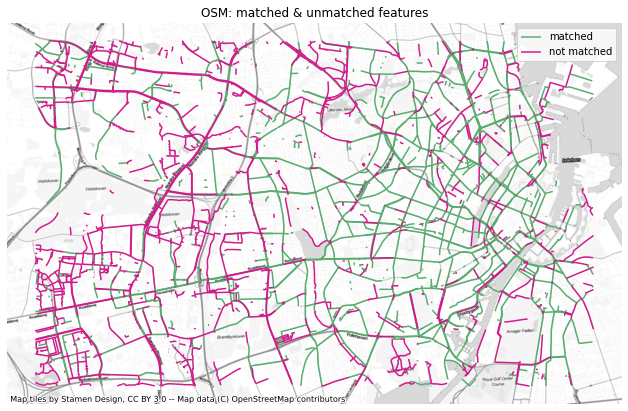

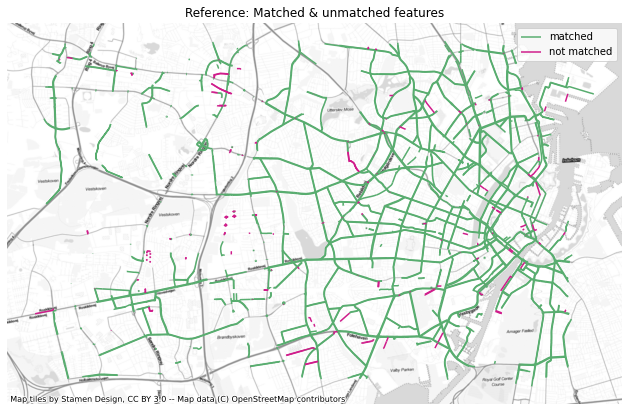

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=pdict["fsmap"])

# OSM
osm_edges_simplified.loc[osm_edges_simplified.edge_id.isin(osm_matched_ids)].plot(
    ax=ax, color=pdict["match"], label="matched"
)
osm_edges_simplified.loc[~osm_edges_simplified.edge_id.isin(osm_matched_ids)].plot(
    ax=ax, color=pdict["nomatch"], label="not matched"
)
cx.add_basemap(ax=ax, crs=study_crs, source=cx_tile_2)
ax.set_title("OSM: Matched & unmatched features")
ax.set_axis_off()
ax.legend()

fig.savefig(
    compare_results_static_maps_fp
    + f"matched_OSM_{buffer_dist}_{hausdorff_threshold}_{angular_threshold}.png",
    dpi=pdict["dpi"],
)

# REF
fig, ax = plt.subplots(1, 1, figsize=pdict["fsmap"])
ref_edges_simplified.loc[ref_edges_simplified.edge_id.isin(ref_matched_ids)].plot(
    ax=ax, color=pdict["match"], label="matched"
)
ref_edges_simplified.loc[~ref_edges_simplified.edge_id.isin(ref_matched_ids)].plot(
    ax=ax, color=pdict["nomatch"], label="not matched"
)
cx.add_basemap(ax=ax, crs=study_crs, source=cx_tile_2)
ax.set_title("Reference: Matched & unmatched features")
ax.set_axis_off()
ax.legend()

fig.savefig(
    compare_results_static_maps_fp
    + f"matched_REF_{buffer_dist}_{hausdorff_threshold}_{angular_threshold}.png",
    dpi=pdict["dpi"],
)

### Summarized results

In [ ]:
count_matched_osm = len(
    osm_edges_simplified.loc[osm_edges_simplified.edge_id.isin(osm_matched_ids)]
)
count_matched_ref = len(
    ref_edges_simplified.loc[ref_edges_simplified.edge_id.isin(ref_matched_ids)]
)

print(
    f"Out of {len(osm_edges_simplified)} OSM edges, {count_matched_osm} were matched with a reference edge."
)
print(
    f"Out of {len(ref_edges_simplified)} reference edges, {count_matched_ref} were matched with an OSM edge."
)

length_matched_osm = osm_edges_simplified.loc[
    osm_edges_simplified.edge_id.isin(osm_matched_ids)
].geometry.length.sum()
length_unmatched_osm = osm_edges_simplified.loc[
    ~osm_edges_simplified.edge_id.isin(osm_matched_ids)
].geometry.length.sum()

length_matched_ref = ref_edges_simplified.loc[
    ref_edges_simplified.edge_id.isin(ref_matched_ids)
].geometry.length.sum()
length_unmatched_ref = ref_edges_simplified.loc[
    ~ref_edges_simplified.edge_id.isin(ref_matched_ids)
].geometry.length.sum()

print(
    f"Out of {osm_edges_simplified.geometry.length.sum()/1000:.2f} km of OSM edges, {length_matched_osm/1000:.2f} km were matched with a reference edge."
)
print(
    f"Out of {ref_edges_simplified.geometry.length.sum()/1000:.2f} km of reference edges, {length_matched_ref/1000:.2f} km were matched with an OSM edge."
)

results_feature_matching = {
    "osm_matched_count": count_matched_osm,
    "osm_matched_count_pct": count_matched_osm / len(osm_edges_simplified) * 100,
    "ref_matched_count": count_matched_ref,
    "ref_matched_count_pct": count_matched_ref / len(ref_edges_simplified) * 100,
    "osm_matched_length": length_matched_osm,
    "osm_matched_length_pct": length_matched_osm
    / osm_edges_simplified.geometry.length.sum()
    * 100,
    "ref_matched_length": length_matched_ref,
    "ref_matched_length_pct": length_matched_ref
    / ref_edges_simplified.geometry.length.sum()
    * 100,
}

Out of 5653 OSM edges, 2863 were matched with a reference edge.
Out of 4705 reference edges, 4309 were matched with an OSM edge.
Out of 809.46 km of OSM edges, 437.19 km were matched with a reference edge.
Out of 626.48 km of reference edges, 602.29 km were matched with an OSM edge.


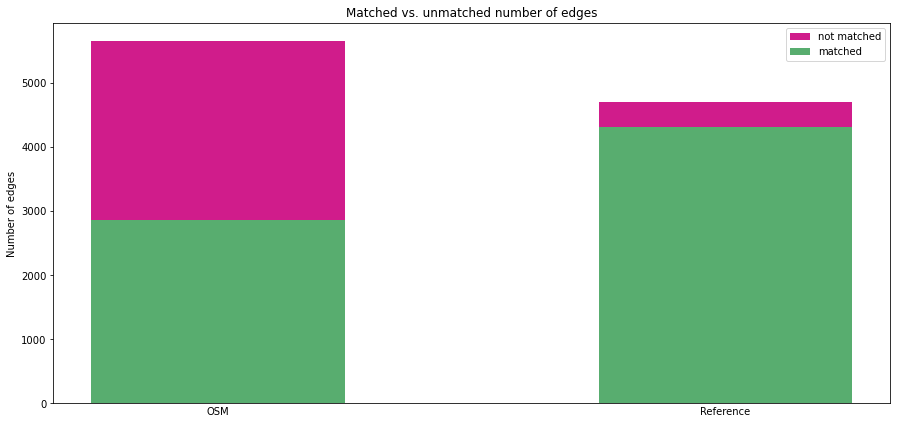

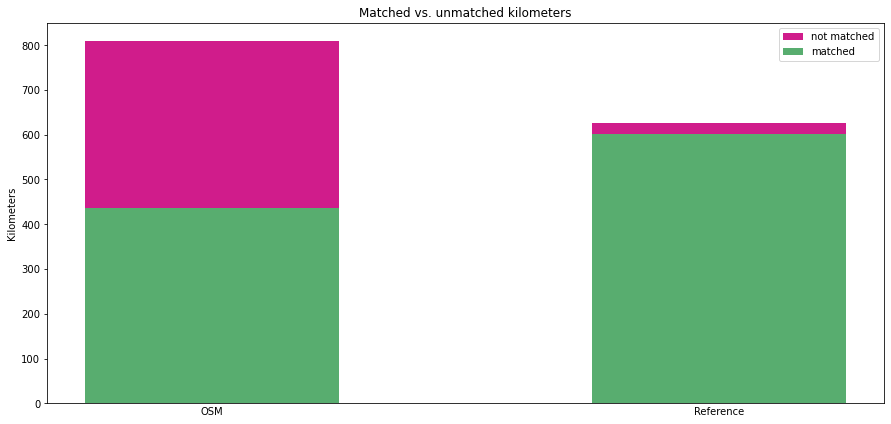

In [ ]:
# PLOT MATCHING SUMMARY

# Edges
fig, ax = plt.subplots(1, 1, figsize=pdict["fsmap"], sharex=True, sharey=False)
bars = ("OSM", "Reference")
x_pos = [0.5, 1.5]

ax.bar(
    x_pos[0],
    [len(osm_edges_simplified)],
    width=pdict["bar_single"],
    color=pdict["nomatch"],
    label="not matched",
)
ax.bar(
    x_pos[0],
    [count_matched_osm],
    width=pdict["bar_single"],
    color=pdict["match"],
    label="matched",
)

ax.bar(
    x_pos[1],
    [len(ref_edges_simplified)],
    width=pdict["bar_single"],
    color=pdict["nomatch"],
)
ax.bar(x_pos[1], [count_matched_ref], width=pdict["bar_single"], color=pdict["match"])

ax.set_title("Matched vs. unmatched number of edges")
ax.set_xticks(x_pos, bars)
ax.set_ylabel("Number of edges")
ax.legend()

fig.savefig(
    compare_results_plots_fp
    + f"matched_unmatched_edges_{buffer_dist}_{hausdorff_threshold}_{angular_threshold}.png",
    dpi=pdict["dpi"],
)

# Kilometers
fig, ax = plt.subplots(1, 1, figsize=pdict["fsmap"], sharex=True, sharey=False)
bars = ("OSM", "Reference")
x_pos = [0.5, 1.5]

ax.bar(
    x_pos[0],
    [osm_edges_simplified.geometry.length.sum() / 1000],
    width=pdict["bar_single"],
    color=pdict["nomatch"],
    label="not matched",
)
ax.bar(
    x_pos[0],
    [length_matched_osm / 1000],
    width=pdict["bar_single"],
    color=pdict["match"],
    label="matched",
)

ax.bar(
    x_pos[1],
    [ref_edges_simplified.geometry.length.sum() / 1000],
    width=pdict["bar_single"],
    color=pdict["nomatch"],
)
ax.bar(
    x_pos[1],
    [length_matched_ref / 1000],
    width=pdict["bar_single"],
    color=pdict["match"],
)

ax.set_title("Matched vs. unmatched kilometers")
ax.set_xticks(x_pos, bars)
ax.set_ylabel("Kilometers")

ax.legend()


fig.savefig(
    compare_results_plots_fp
    + f"matched_unmatched_km_{buffer_dist}_{hausdorff_threshold}_{angular_threshold}.png",
    dpi=pdict["dpi"],
)

________________

## 2. Analyze feature matching results

### Comparison of infrastructure type in matched features

In [ ]:
protection_level_comparison = match_func.update_osm(
    osm_segments,
    osm_edges_simplified,
    segment_matches,
    "protected",
    "edge_id",
    "seg_id",
)

results_feature_matching["protection_level_identical"] = len(
    protection_level_comparison.loc[
        protection_level_comparison.protected
        == protection_level_comparison.protected_matched
    ]
)
results_feature_matching["protection_level_differs"] = len(
    protection_level_comparison.loc[
        protection_level_comparison.protected
        != protection_level_comparison.protected_matched
    ]
)

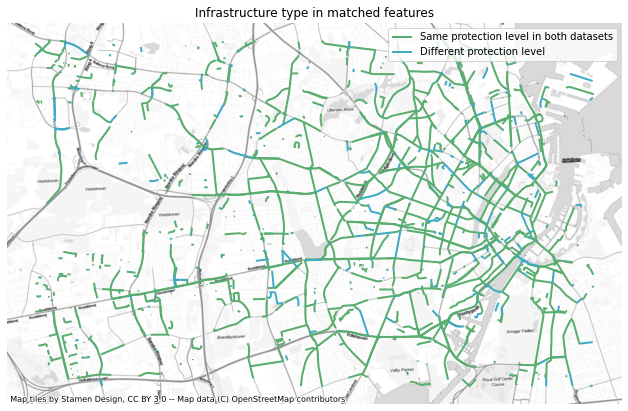

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=pdict["fsmap"])

protection_level_comparison.loc[
    protection_level_comparison.protected
    == protection_level_comparison.protected_matched
].plot(ax=ax, color=green, linewidth=2, label="Same protection level in both datasets")
protection_level_comparison.loc[
    protection_level_comparison.protected
    != protection_level_comparison.protected_matched
].plot(ax=ax, color=blue, linewidth=2, label="Different protection level")

cx.add_basemap(ax=ax, crs=study_crs, source=cx_tile_2)
ax.set_title("Infrastructure type in matched features")
ax.legend()

ax.set_axis_off()

fig.savefig(
    compare_results_plots_fp
    + f"matched_infra_type_{buffer_dist}_{hausdorff_threshold}_{angular_threshold}.png",
    dpi=pdict["dpi"],
)

### Local success rate of feature matching

In the plots below, the count, percent, and length of matched and unmatched features in each dataset are summarized. 

*It should be noted that the number of matched features in one dataset in a grid cell does not necessarily reflect the number of matched features in the other dataset, since an edge can be matched to a corresponding edge in another cell. Moreover, the local count refers to edges intersected with the grid cell. For example, a long bike lane crossing 3 cells will thus be counted as matched in 3 different cells. This does not change the relative distribution of matched/unmatched features, but it does entail that the overall summary of matched/unmatched features above uses a different total count of edges than the plots below.*

In [114]:
osm_matched = osm_edges_simp_joined.loc[
    osm_edges_simp_joined.edge_id.isin(osm_matched_ids)
]

ref_matched = ref_edges_simp_joined.loc[
    ref_edges_simp_joined.edge_id.isin(ref_matched_ids)
]

# Count features in each grid cell
data = [osm_matched, ref_matched]
labels = ["osm_matched", "ref_matched"]

for data, label in zip(data, labels):

    df = eval_func.count_features_in_grid(data, label)

    grid = eval_func.merge_results(grid, df, "left")

    df = eval_func.length_of_features_in_grid(data, label)

    grid = eval_func.merge_results(grid, df, "left")

# Get length of features in each grid cell
data = [osm_edges_simp_joined, ref_edges_simp_joined]
labels = ["osm", "ref"]

for data, label in zip(data, labels):

    df = eval_func.length_of_features_in_grid(data, label)

    grid = eval_func.merge_results(grid, df, "left")

# Compute pct matched
grid["pct_matched_osm"] = (
    grid["count_osm_matched"] / grid["count_osm_simplified_edges"] * 100
)
grid["pct_matched_ref"] = (
    grid["count_ref_matched"] / grid["count_ref_simplified_edges"] * 100
)

results_feature_matching = {}

# Compute local min, max, mean of matched
results_feature_matching["osm_pct_matched_local_min"] = grid.pct_matched_osm.min()
results_feature_matching["osm_pct_matched_local_max"] = grid.pct_matched_osm.max()
results_feature_matching["osm_pct_matched_local_mean"] = grid.pct_matched_osm.mean()
results_feature_matching["ref_pct_matched_local_min"] = grid.pct_matched_ref.min()
results_feature_matching["ref_pct_matched_local_max"] = grid.pct_matched_ref.max()
results_feature_matching["ref_pct_matched_local_mean"] = grid.pct_matched_ref.mean()

# Compute unmatched
grid.loc[
    (grid.count_osm_simplified_edges.notnull()) & (grid.count_osm_matched.isnull()),
    ["count_osm_matched"],
] = 0
grid.loc[
    (grid.count_ref_simplified_edges.notnull()) & (grid.count_ref_matched.isnull()),
    ["count_ref_matched"],
] = 0
grid.loc[
    (grid.count_osm_simplified_edges.notnull()) & (grid.pct_matched_osm.isnull()),
    ["pct_matched_osm"],
] = 0
grid.loc[
    (grid.count_ref_simplified_edges.notnull()) & (grid.pct_matched_ref.isnull()),
    ["pct_matched_ref"],
] = 0

grid.loc[
    (grid.count_osm_simplified_edges.notnull()) & (grid.length_osm_matched.isnull()),
    ["length_osm_matched"],
] = 0
grid.loc[
    (grid.count_ref_simplified_edges.notnull()) & (grid.length_ref_matched.isnull()),
    ["length_ref_matched"],
] = 0

grid["count_osm_unmatched"] = grid.count_osm_simplified_edges - grid.count_osm_matched
grid["count_ref_unmatched"] = grid.count_ref_simplified_edges - grid.count_ref_matched

grid["length_osm_unmatched"] = grid.length_osm - grid.length_osm_matched
grid["length_ref_unmatched"] = grid.length_ref - grid.length_ref_matched

# Compute pct unmatched
grid["pct_unmatched_osm"] = (
    grid["count_osm_unmatched"] / grid["count_osm_simplified_edges"] * 100
)
grid["pct_unmatched_ref"] = (
    grid["count_ref_unmatched"] / grid["count_ref_simplified_edges"] * 100
)

grid.loc[grid.pct_matched_osm == 100, "pct_unmatched_osm"] = 0
grid.loc[grid.pct_matched_ref == 100, "pct_unmatched_ref"] = 0

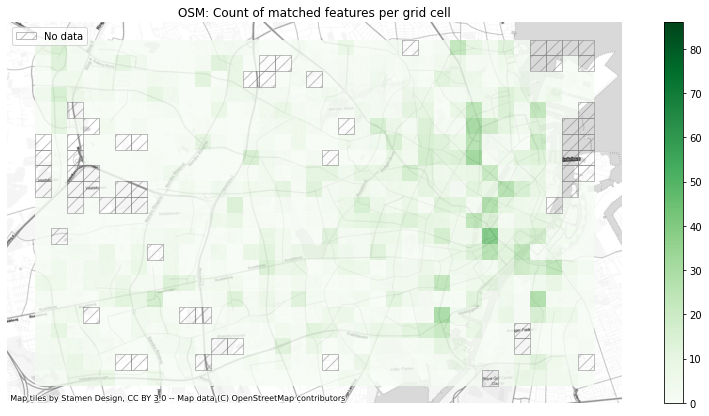

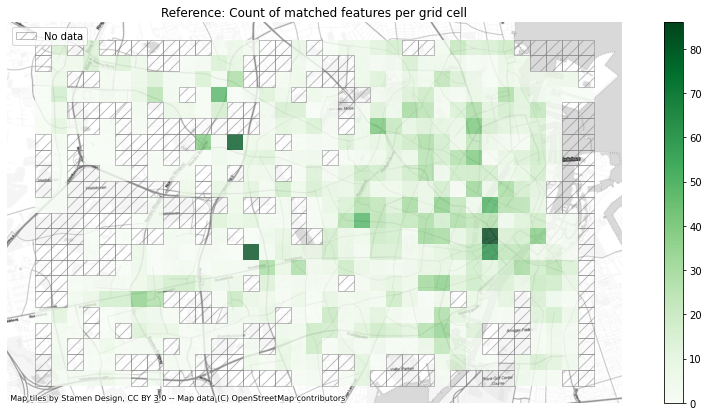

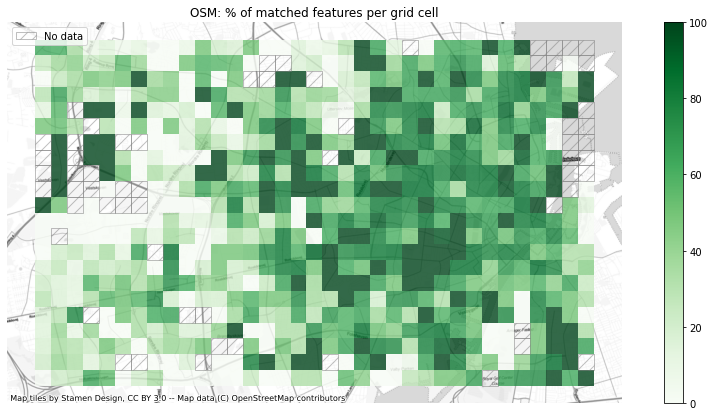

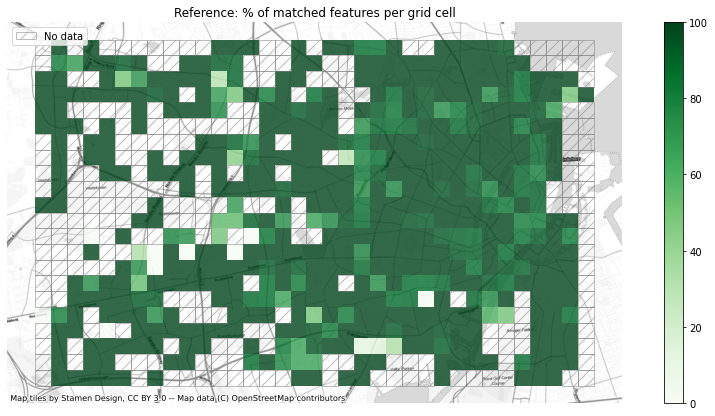

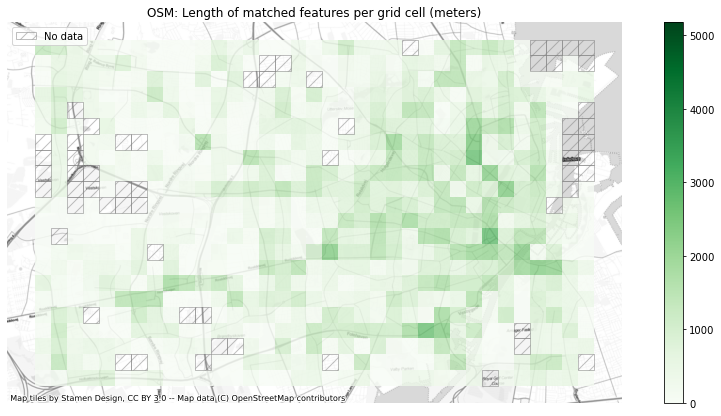

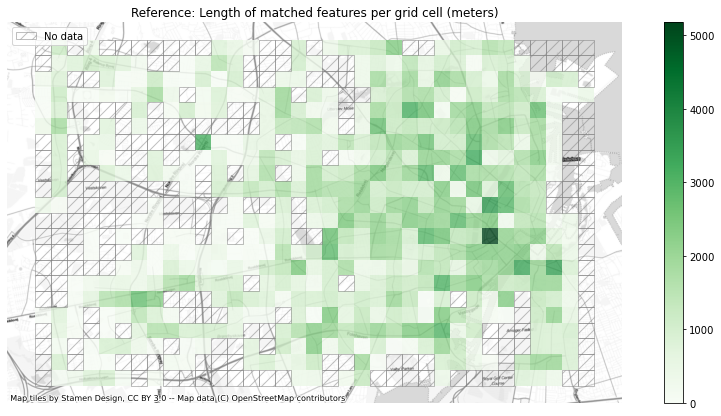

In [115]:
# Plot of matched features

cmaps = [pdict["dens"]] * len(plot_cols)
no_data_cols = ["count_osm_simplified_edges", "count_ref_simplified_edges"]

# Plot count of matched features
norm_count_min = 0
norm_count_max = grid[["count_osm_matched", "count_ref_matched"]].max().max()

plot_cols = ["count_osm_matched", "count_ref_matched"]
plot_titles = [
    "OSM: Count of matched features per grid cell",
    "Reference: Count of matched features per grid cell",
]
filepaths = [
    compare_results_plots_fp
    + f"count_osm_matched_grid_{buffer_dist}_{hausdorff_threshold}_{angular_threshold}.png",
    compare_results_plots_fp
    + f"count_osm_matched_grid_{buffer_dist}_{hausdorff_threshold}_{angular_threshold}.png",
]


plot_func.plot_grid_results(
    grid=grid,
    plot_cols=plot_cols,
    plot_titles=plot_titles,
    filepaths=filepaths,
    cmaps=cmaps,
    alpha=pdict["alpha_grid"],
    cx_tile=cx_tile_2,
    no_data_cols=no_data_cols,
    use_norm=True,
    norm_min=norm_count_min,
    norm_max=norm_count_max,
)


# Plot pct of count of matched features
norm_pct_min = 0
norm_pct_max = 100

plot_cols = ["pct_matched_osm", "pct_matched_ref"]
plot_titles = [
    "OSM: % of matched features per grid cell",
    "Reference: % of matched features per grid cell",
]
filepaths = [
    compare_results_plots_fp
    + f"pct_osm_matched_grid_{buffer_dist}_{hausdorff_threshold}_{angular_threshold}.png",
    compare_results_plots_fp
    + f"pct_ref_matched_grid_{buffer_dist}_{hausdorff_threshold}_{angular_threshold}.png",
]


plot_func.plot_grid_results(
    grid=grid,
    plot_cols=plot_cols,
    plot_titles=plot_titles,
    filepaths=filepaths,
    cmaps=cmaps,
    alpha=pdict["alpha_grid"],
    cx_tile=cx_tile_2,
    no_data_cols=no_data_cols,
    use_norm=True,
    norm_min=norm_pct_min,
    norm_max=norm_pct_max,
)

# Plot length of matched features
norm_length_min = 0
norm_length_max = grid[["length_osm_matched", "length_ref_matched"]].max().max()

plot_cols = ["length_osm_matched", "length_ref_matched"]
plot_titles = [
    "OSM: Length of matched features per grid cell (meters)",
    "Reference: Length of matched features per grid cell (meters)",
]
filepaths = [
    compare_results_plots_fp
    + f"length_osm_matched_grid_{buffer_dist}_{hausdorff_threshold}_{angular_threshold}.png",
    compare_results_plots_fp
    + f"length_ref_matched_grid_{buffer_dist}_{hausdorff_threshold}_{angular_threshold}.png",
]


plot_func.plot_grid_results(
    grid=grid,
    plot_cols=plot_cols,
    plot_titles=plot_titles,
    filepaths=filepaths,
    cmaps=cmaps,
    alpha=pdict["alpha_grid"],
    cx_tile=cx_tile_2,
    no_data_cols=no_data_cols,
    use_norm=True,
    norm_min=norm_length_min,
    norm_max=norm_length_max,
)

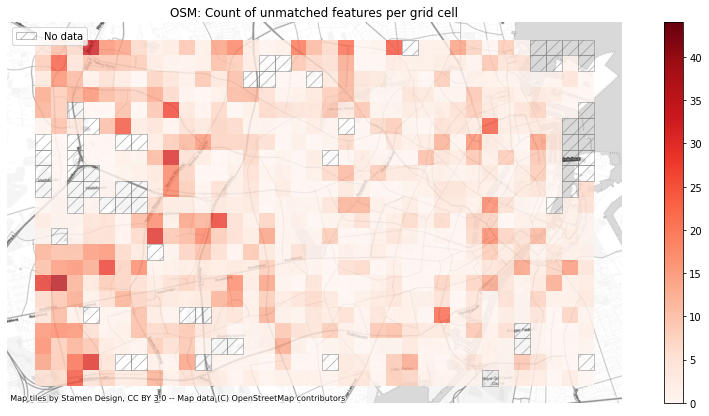

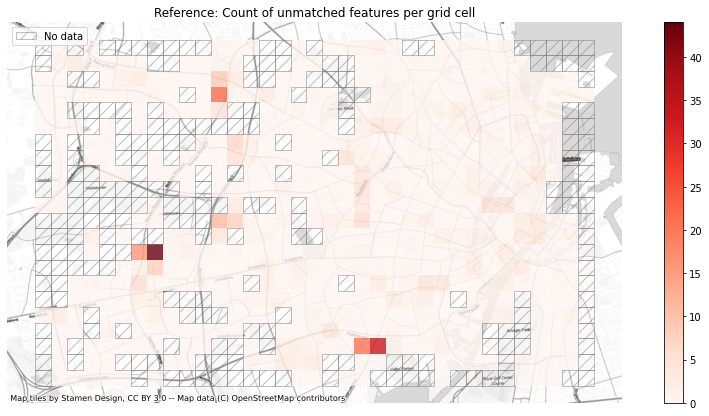

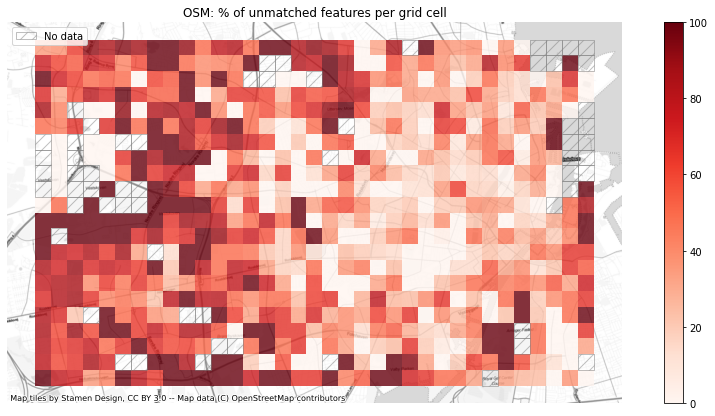

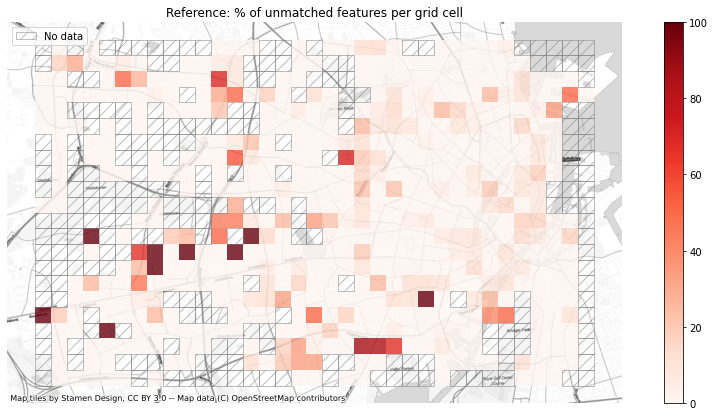

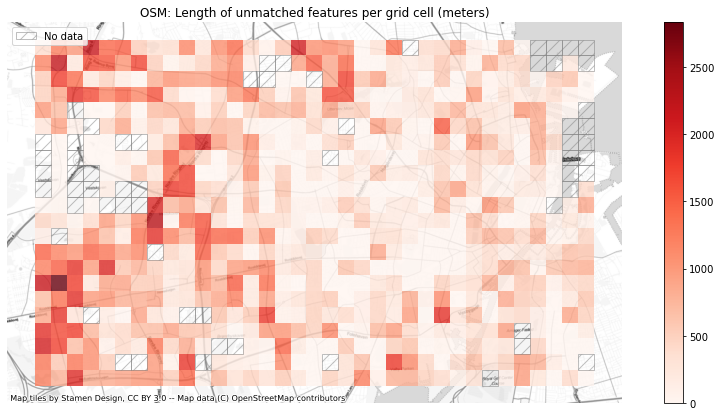

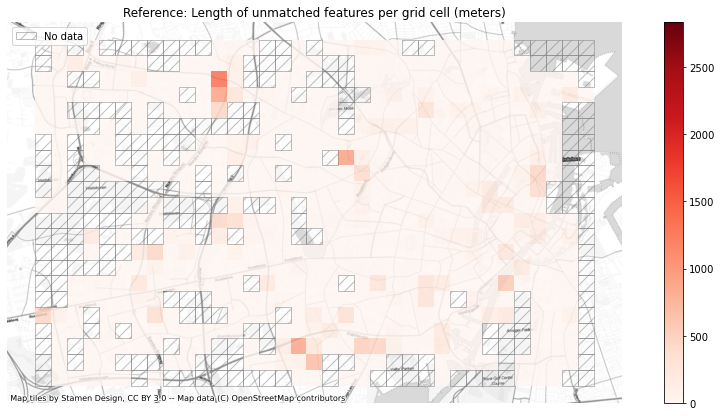

In [116]:
# Plot of unmatched features

cmaps = [pdict["miss"]] * len(plot_cols)
no_data_cols = ["count_osm_simplified_edges", "count_ref_simplified_edges"]

# Plot count of matched features
norm_count_min = 0
norm_count_max = grid[["count_osm_unmatched", "count_ref_unmatched"]].max().max()

plot_cols = ["count_osm_unmatched", "count_ref_unmatched"]
plot_titles = [
    "OSM: Count of unmatched features per grid cell",
    "Reference: Count of unmatched features per grid cell",
]
filepaths = [
    compare_results_plots_fp
    + f"count_osm_unmatched_grid_{buffer_dist}_{hausdorff_threshold}_{angular_threshold}.png",
    compare_results_plots_fp
    + f"count_osm_unmatched_grid_{buffer_dist}_{hausdorff_threshold}_{angular_threshold}.png",
]


plot_func.plot_grid_results(
    grid=grid,
    plot_cols=plot_cols,
    plot_titles=plot_titles,
    filepaths=filepaths,
    cmaps=cmaps,
    alpha=pdict["alpha_grid"],
    cx_tile=cx_tile_2,
    no_data_cols=no_data_cols,
    use_norm=True,
    norm_min=norm_count_min,
    norm_max=norm_count_max,
)


# Plot pct of count of matched features
norm_pct_min = 0
norm_pct_max = 100

plot_cols = ["pct_unmatched_osm", "pct_unmatched_ref"]
plot_titles = [
    "OSM: % of unmatched features per grid cell",
    "Reference: % of unmatched features per grid cell",
]
filepaths = [
    compare_results_plots_fp
    + f"pct_osm_unmatched_grid_{buffer_dist}_{hausdorff_threshold}_{angular_threshold}.png",
    compare_results_plots_fp
    + f"pct_ref_unmatched_grid_{buffer_dist}_{hausdorff_threshold}_{angular_threshold}.png",
]


plot_func.plot_grid_results(
    grid=grid,
    plot_cols=plot_cols,
    plot_titles=plot_titles,
    filepaths=filepaths,
    cmaps=cmaps,
    alpha=pdict["alpha_grid"],
    cx_tile=cx_tile_2,
    no_data_cols=no_data_cols,
    use_norm=True,
    norm_min=norm_pct_min,
    norm_max=norm_pct_max,
)

# Plot length of matched features
norm_length_min = 0
norm_length_max = grid[["length_osm_unmatched", "length_ref_unmatched"]].max().max()

plot_cols = ["length_osm_unmatched", "length_ref_unmatched"]
plot_titles = [
    "OSM: Length of unmatched features per grid cell (meters)",
    "Reference: Length of unmatched features per grid cell (meters)",
]
filepaths = [
    compare_results_plots_fp
    + f"length_osm_unmatched_grid_{buffer_dist}_{hausdorff_threshold}_{angular_threshold}.png",
    compare_results_plots_fp
    + f"length_ref_unmatched_grid_{buffer_dist}_{hausdorff_threshold}_{angular_threshold}.png",
]


plot_func.plot_grid_results(
    grid=grid,
    plot_cols=plot_cols,
    plot_titles=plot_titles,
    filepaths=filepaths,
    cmaps=cmaps,
    alpha=pdict["alpha_grid"],
    cx_tile=cx_tile_2,
    no_data_cols=no_data_cols,
    use_norm=True,
    norm_min=norm_length_min,
    norm_max=norm_length_max,
)

___________________

## 3. Summary

In [73]:
osm_keys = [x for x in results_feature_matching.keys() if "osm" in x]
ref_keys = [x for x in results_feature_matching.keys() if "ref" in x]

osm_values = [results_feature_matching[x] for x in osm_keys]
osm_df = pd.DataFrame(osm_values, index=osm_keys)

osm_df.rename({0: "OSM"}, axis=1, inplace=True)

rename_metrics = {
    "osm_matched_count": "Count of matched edges",
    "osm_matched_count_pct": "Percent matched edges",
    "osm_matched_length": "Length of matched edges (meter)",
    "osm_matched_length_pct": "Percent matched edges (meter)",
    "osm_pct_matched_local_min": "Local min of % matched edges",
    "osm_pct_matched_local_max": "Local max of % matched edges",
    "osm_pct_matched_local_mean": "Local average of % matched edges",
}

osm_df.rename(rename_metrics, inplace=True)

ref_keys = [x for x in results_feature_matching.keys() if "ref" in x]

ref_values = [results_feature_matching[x] for x in ref_keys]
ref_df = pd.DataFrame(ref_values, index=ref_keys)

ref_df.rename({0: "Reference"}, axis=1, inplace=True)

rename_metrics = {
    "ref_matched_count": "Count of matched edges",
    "ref_matched_count_pct": "Percent matched edges",
    "ref_matched_length": "Length of matched edges (meter)",
    "ref_matched_length_pct": "Percent matched edges (meter)",
    "ref_pct_matched_local_min": "Local min of % matched edges",
    "ref_pct_matched_local_max": "Local max of % matched edges",
    "ref_pct_matched_local_mean": "Local average of % matched edges",
}

ref_df.rename(rename_metrics, inplace=True)

combined_results = pd.concat([osm_df, ref_df], axis=1)

combined_results.style.pipe(format_matched_style)

In [76]:
combined_results.to_csv(
    compare_results_data_fp + "feature_matching_summary_stats.csv", index=True
)

____________________

## 4. Save results

In [254]:
with open(
    f"../../results/compare/{study_area}/data/feature_matches__{buffer_dist}_{hausdorff_threshold}_{angular_threshold}.json",
    "w",
) as outfile:
    json.dump(results_feature_matching, outfile)

with open(
    f"../../results/compare/{study_area}/data/grid_results_feature_matching_{buffer_dist}_{hausdorff_threshold}_{angular_threshold}.pickle",
    "wb",
) as f:
    pickle.dump(grid, f)